In [81]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn import linear_model as lm
from scipy.stats import pearsonr
from matplotlib.figure import Figure
import geopandas

In [3]:
# I tried doing this automatically but wasn't sure how to give each csv file a unique df name
#
# with ZipFile('data.zip') as zf:
#     for file in zf.namelist():
#         if file.endswith('.csv'):
#             with zf.open(file,'r') as f:
#                 file = pd.read_csv(f)

with ZipFile('data.zip') as zf:
    with zf.open('data/misc_stats.csv', 'r') as f:
        misc_df = pd.read_csv(f)
    with zf.open('data/opponent_per_100_poss.csv', 'r') as f:
        opponent_per_100_df = pd.read_csv(f)
    with zf.open('data/opponent_shooting.csv', 'r') as f:
        opponent_shooting_df = pd.read_csv(f)
    with zf.open('data/opponent_stats.csv', 'r') as f:
        opponent_stats_df = pd.read_csv(f)
    with zf.open('data/opponents_per_game.csv', 'r') as f:
        opponents_per_game_df = pd.read_csv(f)
    with zf.open('data/team_per_game.csv', 'r') as f:
        team_per_game_df = pd.read_csv(f)
    with zf.open('data/team_shooting.csv', 'r') as f:
        team_shooting_df = pd.read_csv(f)
    with zf.open('data/team_stats.csv', 'r') as f:
        team_stats_df = pd.read_csv(f)
    with zf.open('data/standings.csv', 'r') as f:
        standings_df = pd.read_csv(f)
    with zf.open('data/team_vs_team.csv', 'r') as f:
        team_vs_team_df = pd.read_csv(f)

In [4]:
standings_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Place,Place.1,Conference,Conference.1,Division,Division.1,Division.2,...,All-Star,All-Star.1,Margin,Margin.1,Month,Month.1,Month.2,Month.3,Month.4,Month.5
0,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Pre,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar
1,1,Milwaukee Bucks,53-12,28-3,25-9,34-5,19-7,9-2,13-1,12-2,...,46-8,7-4,3-1,36-7,2-2,15-1,13-2,11-2,10-1,2-4
2,2,Los Angeles Lakers,49-14,23-8,26-6,16-7,33-7,5-4,4-2,7-1,...,41-12,8-2,5-3,25-7,3-1,14-1,9-5,10-4,9-2,4-1
3,3,Toronto Raptors,46-18,23-9,23-9,30-10,16-8,8-4,12-3,10-3,...,40-15,6-3,6-4,21-9,4-1,10-3,9-7,12-3,7-3,4-1
4,4,Los Angeles Clippers,44-20,25-7,19-13,17-6,27-14,5-2,4-3,8-1,...,37-18,7-2,8-1,29-8,4-2,10-4,10-5,9-4,7-4,4-1


In [5]:
#cleaning up the data
clean_df = pd.DataFrame()
standings_clean = standings_df[1:]
standings_clean = standings_clean.sort_values(by = ["Unnamed: 1"], ignore_index = True)
clean_df["Team"] = standings_clean["Unnamed: 1"]
clean_df["Nickname"] = standings_clean["Unnamed: 1"].apply(lambda x: x.split()[-1])
clean_df["Win %"] = standings_clean["Unnamed: 2"].apply(lambda x: x.split("-")[0]).astype(int) / (standings_clean["Unnamed: 2"].apply(lambda x: x.split("-")[0]).astype(int) + standings_clean["Unnamed: 2"].apply(lambda x: x.split("-")[1]).astype(int))
sort_standings = clean_df.sort_values(by = ["Win %"], ascending = False, ignore_index = True)



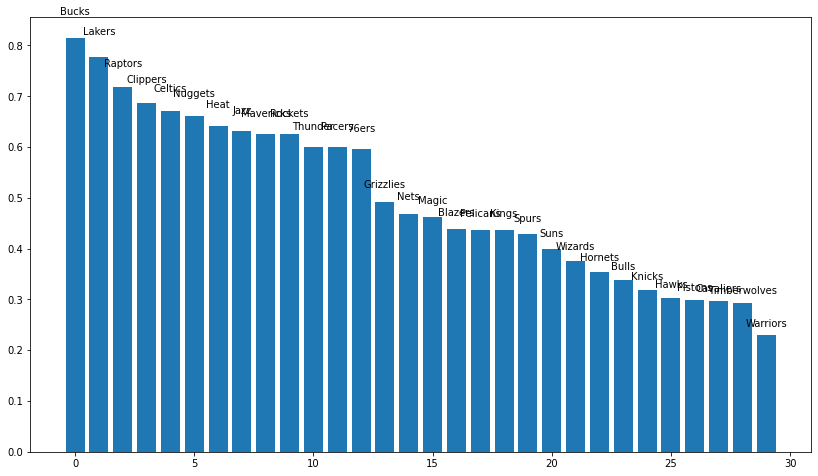

In [6]:
# 1st plot - original
fig, ax = plt.subplots(figsize = (14,8))
nickname = standings_df["Unnamed: 1"].apply(lambda x: x.split()[-1])
record = standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[0]).astype(int) / (standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[0]).astype(int) + standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[1]).astype(int))
x = list(range(30))
rects1 = ax.bar(x, record.sort_values(ascending = False))
def autolabel(rects):
    count = 1
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                nickname[count],
        ha='center', va='bottom')
        count = count + 1
autolabel(rects1)
ax.get_figure().savefig("fig1-before.svg", bbox_inches="tight")

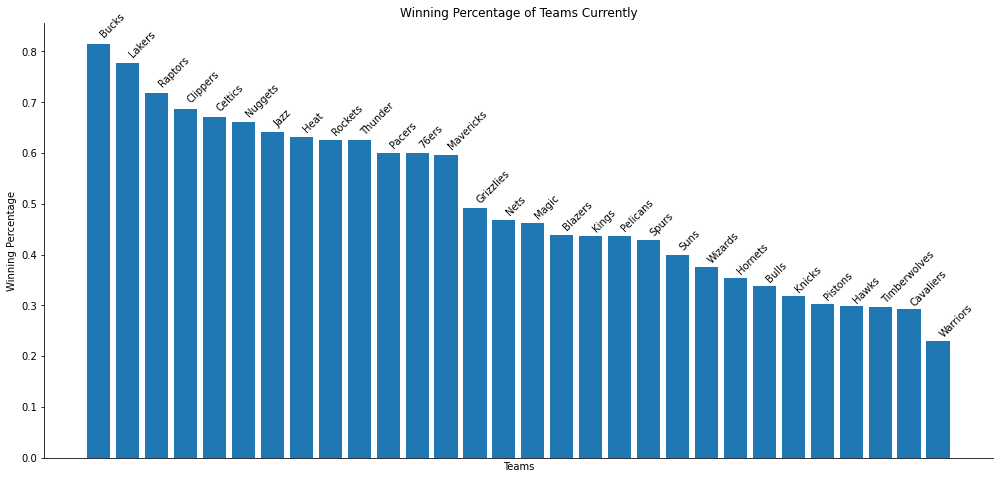

In [7]:
#1st plot - after feedback - no requiements fulfilled
fig, ax = plt.subplots(figsize = (17,8))
x = list(range(30))
rects1 = ax.bar(x, sort_standings["Win %"])
def autolabel(rects):
    count = 0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, 1.01*height,
                sort_standings["Nickname"][count],
        ha='left', va='bottom', rotation = 45)
        count = count + 1
autolabel(rects1)
plt.xticks([],[])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Teams")
ax.set_ylabel("Winning Percentage")
ax.set_title("Winning Percentage of Teams Currently")

ax.get_figure().savefig("fig1.svg", bbox_inches="tight")

In [8]:
#cleaning
team_per_game_clean = team_per_game_df[:30]
team_per_game_clean = team_per_game_clean.sort_values(by = ["Team"], ignore_index = True)

opponents_per_game_clean = opponents_per_game_df[:30]
opponents_per_game_clean = opponents_per_game_clean.sort_values(by = ["Team"], ignore_index = True)

clean_df["Margin"] = team_per_game_clean["PTS"] - opponents_per_game_clean["PTS"]
cor = pearsonr(clean_df["Margin"], clean_df["Win %"])[0]
reg = lm.LinearRegression().fit(clean_df["Margin"].values.reshape(-1,1), clean_df["Win %"])

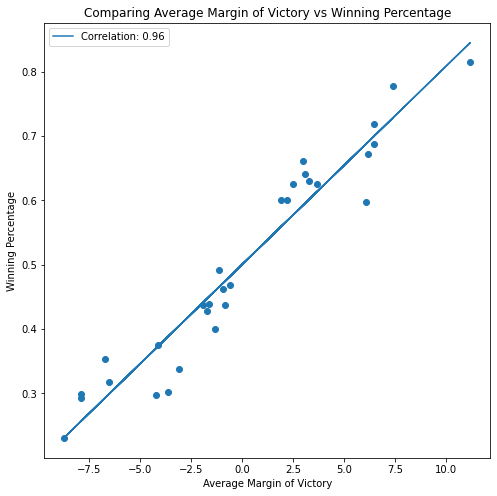

In [9]:
#2nd plot fufills the 3rd requirement
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(clean_df["Margin"], clean_df["Win %"])
line = reg.coef_[0] * clean_df["Margin"] + reg.intercept_
ax.plot(clean_df["Margin"], line, label = "Correlation: %.2f" %cor)
ax.set_xlabel("Average Margin of Victory")
ax.set_ylabel("Winning Percentage")
ax.set_title("Comparing Average Margin of Victory vs Winning Percentage")
ax.legend()

ax.get_figure().savefig("fig2.svg", bbox_inches="tight")

In [10]:
#cleaning
clean_df["Home Win %"] = standings_clean["Place"].apply(lambda x: x.split("-")[0]).astype(int) / (standings_clean["Place"].apply(lambda x: x.split("-")[0]).astype(int) + standings_clean["Place"].apply(lambda x: x.split("-")[1]).astype(int))
misc_clean = misc_df[1:31]
misc_clean = misc_clean.sort_values(by = ["Unnamed: 1"], ignore_index = True)
clean_df["Attend/G"] = misc_clean["Unnamed: 27"].astype(float)

cor = pearsonr(clean_df["Attend/G"], clean_df["Home Win %"])[0]
reg = lm.LinearRegression().fit(clean_df["Attend/G"].values.reshape(-1,1), clean_df["Home Win %"])



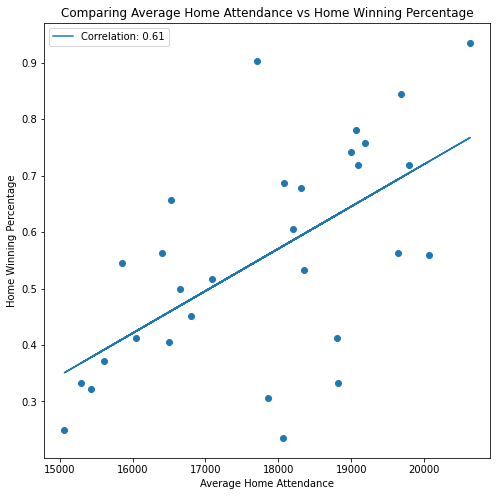

In [11]:
#Plot 3
#Little correlation so corona should affect all teams not having their normal amount of fans similiarlly
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(clean_df["Attend/G"], clean_df["Home Win %"])
line = reg.coef_[0] * clean_df["Attend/G"] + reg.intercept_
ax.plot(clean_df["Attend/G"], line, label = "Correlation: %.2f" %cor)
ax.set_xlabel("Average Home Attendance")
ax.set_ylabel("Home Winning Percentage")
ax.set_title("Comparing Average Home Attendance vs Home Winning Percentage")
ax.legend()

ax.get_figure().savefig("fig3.svg", bbox_inches="tight")

In [12]:
standings_df = standings_df.rename(columns={"Unnamed: 1": "Team"})
wins_per_month_df = standings_df[["Team", "Month.1", "Month.2", "Month.3", "Month.4", "Month.5"]]

wins_per_month_df = wins_per_month_df[1:]
wins_per_month_df["Month.1"] = wins_per_month_df["Month.1"].apply(lambda x: x.split("-")[0]).astype(int) / (wins_per_month_df["Month.1"].apply(lambda x: x.split("-")[0]).astype(int) + wins_per_month_df["Month.1"].apply(lambda x: x.split("-")[1]).astype(int))
wins_per_month_df["Month.2"] = wins_per_month_df["Month.2"].apply(lambda x: x.split("-")[0]).astype(int) / (wins_per_month_df["Month.2"].apply(lambda x: x.split("-")[0]).astype(int) + wins_per_month_df["Month.2"].apply(lambda x: x.split("-")[1]).astype(int))
wins_per_month_df["Month.3"] = wins_per_month_df["Month.3"].apply(lambda x: x.split("-")[0]).astype(int) / (wins_per_month_df["Month.3"].apply(lambda x: x.split("-")[0]).astype(int) + wins_per_month_df["Month.3"].apply(lambda x: x.split("-")[1]).astype(int))
wins_per_month_df["Month.4"] = wins_per_month_df["Month.4"].apply(lambda x: x.split("-")[0]).astype(int) / (wins_per_month_df["Month.4"].apply(lambda x: x.split("-")[0]).astype(int) + wins_per_month_df["Month.4"].apply(lambda x: x.split("-")[1]).astype(int))
wins_per_month_df["Month.5"] = wins_per_month_df["Month.5"].apply(lambda x: x.split("-")[0]).astype(int) / (wins_per_month_df["Month.5"].apply(lambda x: x.split("-")[0]).astype(int) + wins_per_month_df["Month.5"].apply(lambda x: x.split("-")[1]).astype(int))

wins_per_month_df.head()

,Team,Month.1,Month.2,Month.3,Month.4,Month.5
1,Milwaukee Bucks,0.937500,0.866667,0.846154,0.909091,0.333333
2,Los Angeles Lakers,0.933333,0.642857,0.714286,0.818182,0.800000
3,Toronto Raptors,0.769231,0.562500,0.800000,0.700000,0.800000
4,Los Angeles Clippers,0.714286,0.666667,0.692308,0.636364,0.800000
5,Boston Celtics,0.714286,0.769231,0.562500,0.750000,0.400000


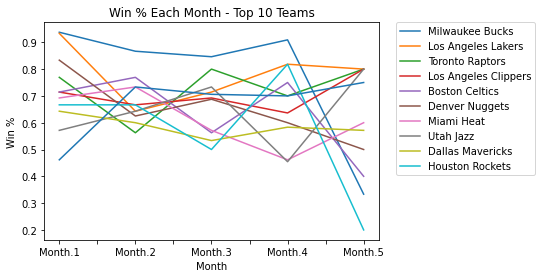

In [32]:
# Plot 4 - need to make it bigger 
# plot is top 10 teams by record because beyond that colors are duplicated

wins_per_month_df = wins_per_month_df[0:11]
plot = wins_per_month_df.transpose()[1:].plot()
plot.legend(standings_df["Team"][1:11],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.set_xlabel("Month")
plot.set_ylabel("Win %")
plot.set_title("Win % Each Month - Top 10 Teams")
plot.get_figure().savefig("fig4.svg", bbox_inches="tight")

In [44]:
#cleaning
# print(misc_clean)
clean_df["eFG%"] = misc_clean["Offense Four Factors"].rank(ascending = False)
clean_df["TOV%"] = misc_clean["Offense Four Factors.1"].rank(ascending = True)
clean_df["ORB%"] = misc_clean["Offense Four Factors.2"].rank(ascending = False)
clean_df["FT/FGA"] = misc_clean["Offense Four Factors.3"].rank(ascending = False)
top_teams_df = clean_df.sort_values(by = ["Win %"], ignore_index = True, ascending = False)[0:5]
print(top_teams_df)


Team  Nickname     Win %  Margin  Home Win %  Attend/G  \
0       Milwaukee Bucks     Bucks  0.815385    11.2    0.903226   17711.0   
1    Los Angeles Lakers    Lakers  0.777778     7.4    0.741935   18997.0   
2       Toronto Raptors   Raptors  0.718750     6.5    0.718750   19796.0   
3  Los Angeles Clippers  Clippers  0.687500     6.5    0.781250   19068.0   
4        Boston Celtics   Celtics  0.671875     6.2    0.718750   19090.0   

   eFG%  TOV%  ORB% FT/FTA  FT/FGA  
0   1.0  14.5  26.0   .196    16.5  
1   4.5  19.0   3.5   .196    16.5  
2   8.0  14.5  22.5   .205    11.0  
3  11.5  12.5   6.0   .232     2.0  
4  18.0   6.0   7.5   .204    12.5  


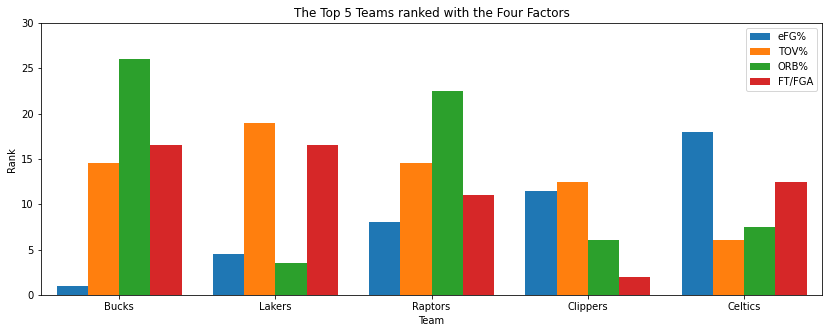

In [83]:
#plot 5
pos = list(range(len(top_teams_df["eFG%"])))
fig, ax = plt.subplots(figsize=(14,5))
width = 0.2
plt.bar(pos,  top_teams_df["eFG%"],  width, label=top_teams_df["Nickname"][0])# bottom = top_teams_df["eFG%"]) 
plt.bar([p + width for p in pos], top_teams_df["TOV%"], width, label=top_teams_df["Nickname"][1]) 
plt.bar([p + width*2 for p in pos], top_teams_df["ORB%"], width, label=top_teams_df["Nickname"][2]) 
plt.bar([p + width*3 for p in pos],
        top_teams_df["FT/FGA"], width, label=top_teams_df["Nickname"][3]) 

ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(top_teams_df["Nickname"])
ax.set_xlabel("Team")
ax.set_ylabel("Rank")
ax.set_title("The Top 5 Teams ranked with the Four Factors")
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 30])
# ax.invert_yaxis()
# for bar in bars:
#     bar.sticky_edges.y[:] = [df['y'].values.max()]
# ax.autoscale()
plt.legend(["eFG%", "TOV%", "ORB%", "FT/FGA"])
plt.show()
ax.get_figure().savefig("fig5.svg", bbox_inches="tight")

Text(-91, 43, 'Bucks')

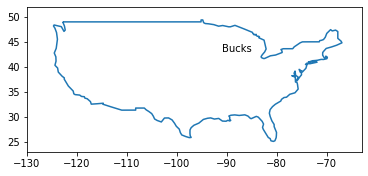

In [126]:
#no idea
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

america = world[world["name"] == "United States of America"]

ax = america.boundary.plot()
ax.set_xlim(-130, -63)
ax.set_ylim(23, 52)
ax.text(-91, 43, "Bucks")

